In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
from nilearn import surface
import pingouin

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'


bids_folder = '/data2/risk_precision/ds-numrisk/'

In [4]:
neural_results = pd.read_csv(op.join(bids_folder, 'derivatives', 'summary_data', 'neural_results_aug2021.tsv'), sep='\t')
neural_results = neural_results.set_index(['type', 'subject', 'mask'])
neural_results['log(neural precision)'] = np.log(neural_results['neural precision'])


behav = pd.read_csv('~/Downloads/riskPrecision_data.csv').set_index('subject')
behav.index = behav.index.astype(int)

In [5]:
from pandas import IndexSlice as ix_

In [6]:
formiguel = neural_results.loc[ix_['trialwise', :, ['NPC', 'NPC_L', 'NPC_R']], :].unstack('mask')[['neural precision', 'slope']]


formiguel.to_csv('/data2/risk_precision/ds-numrisk/derivatives/summary_data/miguel_aug2021.csv')

In [7]:
df = behav.join(neural_results)

In [8]:
df['slope/intercept'] = df['slope'] / df['intercept']
df['slope2/intercept2'] = df['slope2'] / df['intercept2']

In [9]:
df['log(sd)'] = np.log(df['sd'])

In [10]:
df['log(mutual information)'] = np.log(df['mutual information'])

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


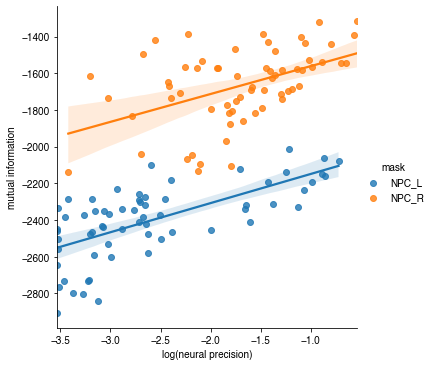

In [11]:
sns.lmplot('log(neural precision)', 'mutual information', hue='mask', data=df.query('(mask in ["NPC_L", "NPC_R"]) & (type == "trialwise")').reset_index())

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


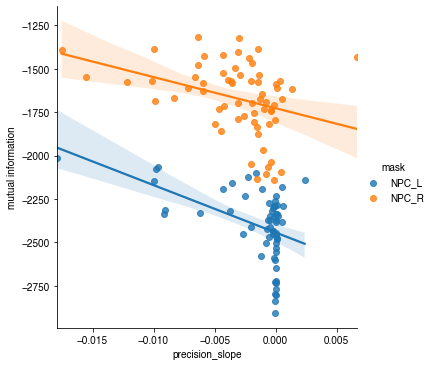

In [12]:
sns.lmplot('precision_slope', 'mutual information', hue='mask', data=df.query('(mask in ["NPC_L", "NPC_R"]) & (type == "trialwise")').reset_index())

In [13]:
import matplotlib.pyplot as plt

In [14]:
sns.set_context('poster')

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


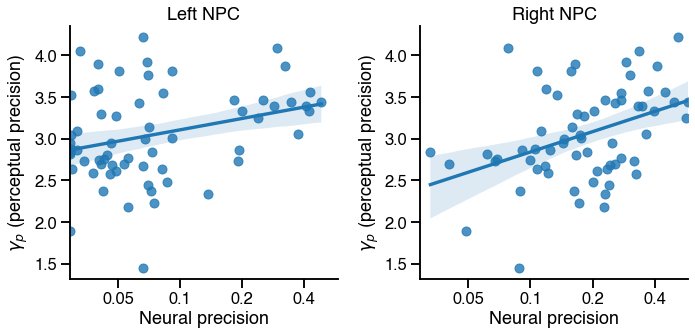

In [15]:
tmp = df.query('(mask in ["NPC_L", "NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})

sns.set_context('talk')
fac = sns.lmplot('log(neural precision)', 'mag_prec', col='mask', hue='mask', 
                 palette=sns.color_palette()[:1],
                 sharey=False,
                 aspect=1.,
                 data=tmp)

fac.set(ylabel='$\gamma_p$ (perceptual precision)', xlabel='Neural precision')
# fac.axes.ravel()[0].set_xticklabels('Neural precision')
plt.xticks(np.log([.05, .1, .2, .4]), [.05, .1, .2, .4])


plt.tight_layout()
fac.set_titles('{col_name}')

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/decoding/behavioral_neural_precision.pdf',
           transparent=True)

In [16]:
sns.set_context('poster')

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


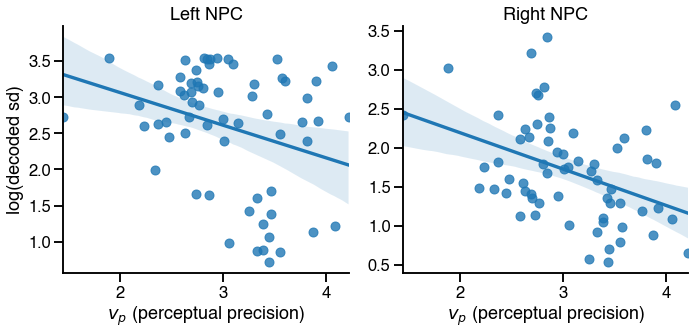

In [17]:
tmp = df.query('(mask in ["NPC_L", "NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})

sns.set_context('talk')
fac = sns.lmplot('mag_prec', 'log(sd)', col='mask', hue='mask', 
                 palette=sns.color_palette()[:1],
                 sharey=False,
                 aspect=1.,
                 data=tmp)

fac.set(xlabel='$v_p$ (perceptual precision)')
fac.axes.ravel()[0].set_ylabel('log(decoded sd)')
# plt.xticks(np.log([.05, .1, .2, .4]), [.05, .1, .2, .4])

plt.tight_layout()
fac.set_titles('{col_name}')

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/decoding/behavioral_neural_precision.pdf',
           transparent=True)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


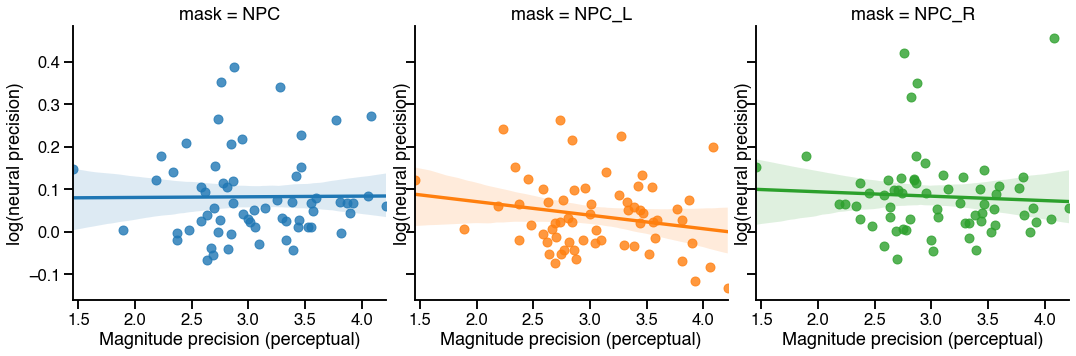

In [18]:
sns.set_context('talk')
fac = sns.lmplot('mag_prec', 'slope', col='mask', hue='mask', 
                 data=df.query('(mask in ["NPC", "NPC_L", "NPC_R"]) & (type == "trialwise")').reset_index())

fac.set(xlabel='Magnitude precision (perceptual)')
fac.set(ylabel='log(neural precision)')

In [21]:
from itertools import product

tmp = df.xs('trialwise', 0, 'type').query('mask in ["NPC", "NPC_L", "NPC_R"]')
# tmp = tmp.drop(45, 0, level='subject')

tmp['log(sd)'] = np.log(tmp['sd'])

rs = []
# for x, y in product(['mag_noise3', 'mag_prec', 'risknoise_pool', 'rnp_pool'], ['mutual information', 'accuracy', 'r', 'r_2', 'r_map2', 'sd', 'sd2', 'slope', 'slope2']):
# for x, y in product(['mag_noise3', 'mag_prec', 'risknoise_pool', 'riskprec_pool', 'rnp_pool'], ['r_2', 'sd', 'slope',]):
for x, y in product(['mag_prec', 'riskprec_coin', 'riskprec_sym', 'riskprec_pool', 'rnp_coin', 'rnp_sym', 'rnp_pool'], ['neural precision', 'log(neural precision)', 'precision_slope', 'r_2', 'sd', 'slope', 'log(sd)', 'mutual information']):
    r = tmp.groupby('mask').apply(lambda d: pingouin.corr(d[x], d[y], 'one-sided')).reset_index()
    
    r['x'], r['y'] = x, y
    
    r = r.set_index(['mask']).drop('level_1', 1)
    
#     r = pd.concat((r, tmp.groupby('mask').apply(lambda d: pingouin.corr(d[x], d[y], 'two-sided')).droplevel(1)[['p-val', 'BF10']]), 1)
    
    r = r.reset_index().set_index(['x', 'y', 'mask'])
    
    rs.append(r)
    
r = pd.concat(rs)


<ipython-input-21-e18c10db26cd>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  r = r.set_index(['mask']).drop('level_1', 1)


In [22]:
r.loc[ix_[['riskprec_coin', 'riskprec_sym'], ['neural precision', 'log(neural precision)', 'slope', 'mutual information']], :]

n         r          CI95%  \
x             y                     mask                                 
riskprec_coin neural precision      NPC    64  0.109784  [-0.14, 0.35]   
                                    NPC_L  64  0.070726  [-0.18, 0.31]   
                                    NPC_R  64  0.112840  [-0.14, 0.35]   
              log(neural precision) NPC    64  0.103626  [-0.15, 0.34]   
                                    NPC_L  64  0.059404   [-0.19, 0.3]   
                                    NPC_R  64  0.121598  [-0.13, 0.36]   
              slope                 NPC    64 -0.241449   [-0.46, 0.0]   
                                    NPC_L  64 -0.149936   [-0.38, 0.1]   
                                    NPC_R  64 -0.213259  [-0.44, 0.03]   
              mutual information    NPC    64 -0.143505  [-0.38, 0.11]   
                                    NPC_L  64 -0.059157   [-0.3, 0.19]   
                                    NPC_R  64 -0.121912  [-0.36, 0.13]   
riskprec_sym  neural precision      NPC    64  0.099053  [-0.15, 0.34]   
                                    NPC_L  64  0.050688   [-0.2, 0.29]   
                                    NPC_R  64  0.093718  [-0.16, 0.33]   
              log(neural precision) NPC    64  0.091413  [-0.16, 0.33]   
                                    NPC_L  64  0.074764  [-0.17, 0.31]   
                                    NPC_R  64  0.117794  [-0.13, 0.35]   
              slope                 NPC    64 -0.107341  [-0.34, 0.14]   
                                    NPC_L  64 -0.055851   [-0.3, 0.19]   
                                    NPC_R  64 -0.180070  [-0.41, 0.07]   
              mutual information    NPC    64 -0.136829  [-0.37, 0.11]   
                                    NPC_L  64 -0.117054  [-0.35, 0.13]   
                                    NPC_R  64 -0.180255  [-0.41, 0.07]   

                                              p-val   BF10     power  
x             y                     mask                              
riskprec_coin neural precision      NPC    0.193911  0.361  0.218757  
                                    NPC_L  0.289327  0.257  0.138647  
                                    NPC_R  0.187334  0.371  0.226012  
              log(neural precision) NPC    0.207574  0.341  0.204565  
                                    NPC_L  0.320509  0.235  0.119812  
                                    NPC_R  0.169241  0.404  0.247574  
              slope                 NPC    0.027299  1.844  0.615855  
                                    NPC_L  0.118494  0.543  0.324596  
                                    NPC_R  0.045325  1.204  0.524192  
              mutual information    NPC    0.128968  0.506  0.306212  
                                    NPC_L  0.321205  0.235  0.119422  
                                    NPC_R  0.168613  0.405  0.248368  
riskprec_sym  neural precision      NPC    0.218070  0.327  0.194400  
                                    NPC_L  0.345400   0.22  0.106613  
                                    NPC_R  0.230685  0.312  0.182948  
              log(neural precision) NPC    0.236257  0.305  0.178136  
                                    NPC_L  0.278552  0.265  0.145836  
                                    NPC_R  0.176960  0.389  0.238072  
              slope                 NPC    0.199265  0.352  0.213058  
                                    NPC_L  0.330569  0.229  0.114297  
                                    NPC_R  0.077247  0.773  0.416423  
              mutual information    NPC    0.140485  0.471  0.287666  
                                    NPC_L  0.178487  0.386  0.236247  
                                    NPC_R  0.077032  0.775  0.417008

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


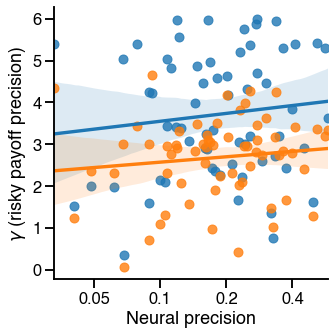

In [23]:
tmp = df.query('(mask in ["NPC_R"]) & (type == "trialwise")').reset_index()


tmp['log(slope)'] = np.log(tmp['slope'])

tmp = tmp.set_index(['subject', 'slope', 'sd', 'log(sd)', 'log(slope)', 'log(neural precision)'])[['riskprec_coin', 'riskprec_sym']]
tmp.columns = ['Coins', 'Symbolic numbers']
tmp.columns.name = 'Stimulus format'


sns.lmplot('log(neural precision)', 'Risky choice precision', 
           hue_order=['Symbolic numbers', 'Coins'],
           hue='Stimulus format', data=tmp.stack().to_frame('Risky choice precision').reset_index(),
          legend=False)
# plt.xlim(-7, 0)

plt.xticks(np.log([.05, .1, .2, .4]), [.05, .1, .2, .4])

plt.xlabel('Neural precision')
plt.ylabel('$\gamma$ (risky payoff precision)')

plt.tight_layout()
plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/brainbehavior/riskprec_np.pdf', transparent=False)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


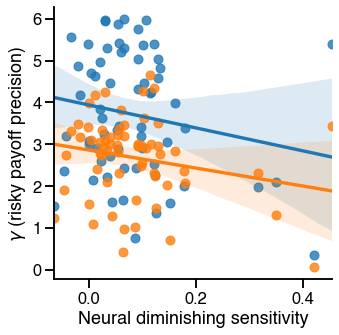

In [24]:
tmp = df.query('(mask in ["NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})
tmp['log(slope)'] = np.log(tmp['slope'])



tmp = tmp.set_index(['subject', 'slope', 'sd', 'log(sd)', 'log(slope)', 'neural precision'])[['riskprec_coin', 'riskprec_sym']]
tmp.columns = ['Coins', 'Symbolic numbers']
tmp.columns.name = 'Stimulus format'
sns.lmplot('slope', 'Risky choice precision', 
           hue_order=['Symbolic numbers', 'Coins'],
           hue='Stimulus format', data=tmp.stack().to_frame('Risky choice precision').reset_index(),
          legend=False)
# # plt.xlim(-7, 0)
plt.xlabel('Neural diminishing sensitivity')
plt.tight_layout()
plt.ylabel('$\gamma$ (risky payoff precision)')


plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/brainbehavior/riskprec_slope.pdf', transparent=False)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


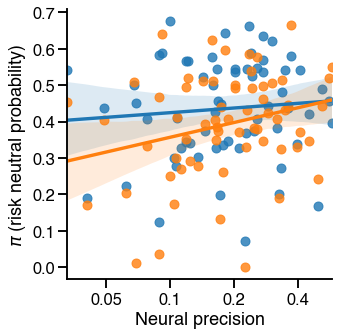

In [25]:
tmp = df.query('(mask in ["NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})
tmp['log(slope)'] = np.log(tmp['slope'])



tmp = tmp.set_index(['subject', 'slope', 'sd', 'log(sd)', 'log(slope)', 'log(neural precision)'])[['rnp_coin', 'rnp_sym']]
tmp.columns = ['Coins', 'Symbolic numbers']
tmp.columns.name = 'Stimulus format'
sns.lmplot('log(neural precision)', 'Risk neutral probability', 
           hue_order=['Symbolic numbers', 'Coins'],
           hue='Stimulus format', data=tmp.stack().to_frame('Risk neutral probability').reset_index(),
          legend=False)
# plt.xlim(-7, 0)
plt.xlabel('Neural precision')

plt.xticks(np.log([.05, .1, .2, .4]), [.05, .1, .2, .4])

plt.tight_layout()
plt.ylabel('$\pi$ (risk neutral probability)')

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/brainbehavior/rnp_np.pdf', 
            transparent=False,
           bbox_inches="tight")

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


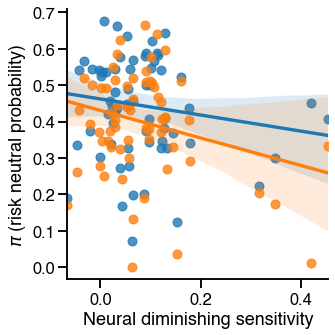

In [26]:
tmp = df.query('(mask in ["NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})
tmp['log(slope)'] = np.log(tmp['slope'])

# tmp = tmp[tmp['slope'] < .3]

tmp = tmp.set_index(['subject', 'slope', 'sd', 'log(sd)', 'log(slope)', 'neural precision'])[['rnp_coin', 'rnp_sym']]
tmp.columns = ['Coins', 'Symbolic numbers']
tmp.columns.name = 'Stimulus format'
fac = sns.lmplot('slope', 'Risk neutral probability', 
           hue_order=['Symbolic numbers', 'Coins'],
                 robust=True,
           hue='Stimulus format', data=tmp.stack().to_frame('Risk neutral probability').reset_index(),
          legend=False)
# plt.xlim(-.1, .4)
# fac.set(xscale='log')
plt.xlabel('Neural diminishing sensitivity')
plt.ylabel('$\pi$ (risk neutral probability)')

plt.tight_layout()

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/brainbehavior/rnp_slope.pdf', 
            bbox_inches='tight',
            transparent=False)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


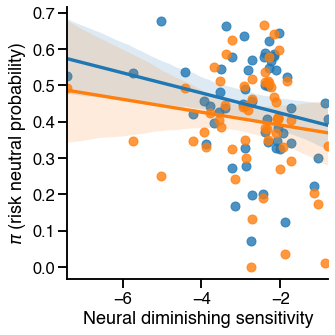

In [27]:
tmp = df.query('(mask in ["NPC_R"]) & (type == "trialwise")').reset_index()

tmp['mask'] = tmp['mask'].map({'NPC_L':'Left NPC', 'NPC_R':'Right NPC'})
tmp['log(slope)'] = np.log(tmp['slope'])

# tmp = tmp[tmp['slope'] < .3]

tmp = tmp.set_index(['subject', 'slope', 'sd', 'log(sd)', 'log(slope)', 'neural precision'])[['rnp_coin', 'rnp_sym']]
tmp.columns = ['Coins', 'Symbolic numbers']
tmp.columns.name = 'Stimulus format'
fac = sns.lmplot('log(slope)', 'Risk neutral probability', 
           hue_order=['Symbolic numbers', 'Coins'],
                 robust=True,
           hue='Stimulus format', data=tmp.stack().to_frame('Risk neutral probability').reset_index(),
          legend=False)
# plt.xlim(-.1, .4)
# fac.set(xscale='log')
plt.xlabel('Neural diminishing sensitivity')
plt.ylabel('$\pi$ (risk neutral probability)')

plt.tight_layout()

plt.savefig('/Users/gdehol/Dropbox/Science/numerosity_risk/paper/version autumn 2021/figures/brainbehavior/rnp_slope.pdf', 
            bbox_inches='tight',
            transparent=False)

In [28]:
## from itertools import product


df['log(slope)'] = np.log(df['slope'])
tmp = df.xs('trialwise', 0, 'type').query('mask in ["NPC", "NPC_L", "NPC_R", "NPC1_L"]')
# tmp = tmp.drop(45, 0, level='subject')

rs = []
# for x, y in product(['mag_noise3', 'mag_prec', 'risknoise_pool', 'rnp_pool'], ['mutual information', 'accuracy', 'r', 'r_2', 'r_map2', 'sd', 'sd2', 'slope', 'slope2']):
# for x, y in product(['mag_noise3', 'mag_prec', 'risknoise_pool', 'riskprec_pool', 'rnp_pool'], ['r_2', 'sd', 'slope',]):
for x, y in product(['mag_prec', 'riskprec_coin', 'riskprec_sym', 'riskprec_pool', 'rnp_coin', 'rnp_sym', 'rnp_pool'], ['log(sd)', 'neural precision', 'log(neural precision)', 'precision_slope', 'r_2', 'sd', 'slope', 'log(slope)']):
    r = tmp.groupby('mask').apply(lambda d: pingouin.corr(d[x], d[y], 'two-sided')).reset_index()
    
    r['x'], r['y'] = x, y
    
    r = r.set_index(['mask']).drop('level_1', 1)
    
#     r = pd.concat((r, tmp.groupby('mask').apply(lambda d: pingouin.corr(d[x], d[y], 'one-sided')).droplevel(1)[['p-val', 'BF10']]), 1)
    
    r = r.reset_index().set_index(['x', 'y', 'mask'])
    
    rs.append(r)
    
r = pd.concat(rs)
# r

/Users/gdehol/miniconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-28-a9ea5297771f>:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  r = r.set_index(['mask']).drop('level_1', 1)


In [29]:
r.loc[[('mag_prec', 'log(neural precision)', 'NPC_L'), ('mag_prec', 'log(neural precision)', 'NPC_R')]]

n         r         CI95%     p-val  \
x        y                     mask                                          
mag_prec log(neural precision) NPC_L  64  0.297791  [0.06, 0.51]  0.016854   
                               NPC_R  64  0.404148  [0.18, 0.59]  0.000926   

                                        BF10     power  
x        y                     mask                     
mag_prec log(neural precision) NPC_L   2.546  0.675400  
                               NPC_R  33.236  0.920791

In [30]:
r.loc[[('mag_prec', 'slope', 'NPC_L'), ('mag_prec', 'slope', 'NPC_R')]]

n         r          CI95%     p-val   BF10     power
x        y     mask                                                         
mag_prec slope NPC_L  64 -0.210449  [-0.43, 0.04]  0.095086  0.609  0.389701
               NPC_R  64 -0.059464   [-0.3, 0.19]  0.640680  0.174  0.075198

In [31]:
r.loc[[('riskprec_coin', 'log(neural precision)', 'NPC_R'), ('riskprec_sym', 'log(neural precision)', 'NPC_R')]]

,,,n,r,CI95%,p-val,BF10,power
x,y,mask,,,,,,
riskprec_coin,log(neural precision),NPC_R,64,0.121598,"[-0.13, 0.36]",0.338483,0.244,0.160356
riskprec_sym,log(neural precision),NPC_R,64,0.117794,"[-0.13, 0.35]",0.353920,0.238,0.153294


In [32]:
r.loc[[('riskprec_coin', 'slope', 'NPC_R'), ('riskprec_sym', 'slope', 'NPC_R')]]

,,,n,r,CI95%,p-val,BF10,power
x,y,mask,,,,,,
riskprec_coin,slope,NPC_R,64,-0.213259,"[-0.44, 0.03]",0.090651,0.633,0.398600
riskprec_sym,slope,NPC_R,64,-0.180070,"[-0.41, 0.07]",0.154493,0.42,0.298738


In [33]:
r.loc[[('rnp_coin', 'log(neural precision)', 'NPC_R'), ('rnp_sym', 'log(neural precision)', 'NPC_R')]]

,,,n,r,CI95%,p-val,BF10,power
x,y,mask,,,,,,
rnp_coin,log(neural precision),NPC_R,64,0.258423,"[0.01, 0.47]",0.039227,1.247,0.547430
rnp_sym,log(neural precision),NPC_R,64,0.085259,"[-0.16, 0.32]",0.502955,0.194,0.102858


In [34]:
r.loc[[('rnp_coin', 'slope', 'NPC_R'), ('rnp_sym', 'slope', 'NPC_R')]]

,,,n,r,CI95%,p-val,BF10,power
x,y,mask,,,,,,
rnp_coin,slope,NPC_R,64,-0.267877,"[-0.48, -0.02]",0.032350,1.464,0.578896
rnp_sym,slope,NPC_R,64,-0.140040,"[-0.37, 0.11]",0.269727,0.283,0.198056


In [35]:
r.loc[[('rnp_coin', 'log(slope)', 'NPC_R'), ('rnp_sym', 'log(slope)', 'NPC_R')]]

,,,n,r,CI95%,p-val,BF10,power
x,y,mask,,,,,,
rnp_coin,log(slope),NPC_R,56,-0.181592,"[-0.42, 0.09]",0.180431,0.4,0.270230
rnp_sym,log(slope),NPC_R,56,-0.232610,"[-0.47, 0.03]",0.084494,0.711,0.412271


/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='slope', ylabel='Density'>

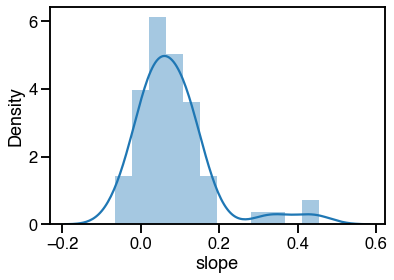

In [36]:
sns.distplot(df.loc[('trialwise', slice(None), 'NPC_R'), :]['slope'])

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='neural precision', ylabel='Density'>

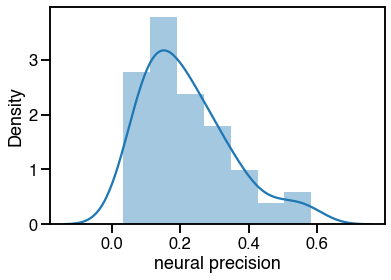

In [37]:
sns.distplot(df.loc[('trialwise', slice(None), 'NPC_R'), :]['neural precision'])

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log(neural precision)', ylabel='Density'>

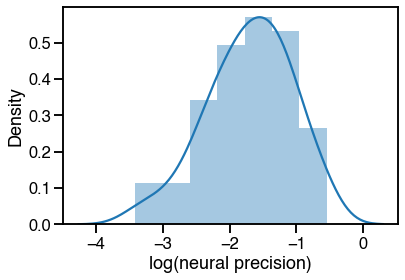

In [38]:
sns.distplot(df.loc[('trialwise', slice(None), 'NPC_R'), :]['log(neural precision)'])

In [39]:
import statsmodels.api as sm

In [40]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['riskprec_coin'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.TrimmedMean()).fit()
huber_t.summary()

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          riskprec_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:15:24                                         
No. Iterations:                    50                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2330      0.090     35.732      0.000       3.056       3.410
slope         -4.5165      0.711     -6.351      0.000      -5.910      -3.123
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [41]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['riskprec_sym'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.TrimmedMean()).fit()
huber_t.summary()

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           riskprec_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:15:24                                         
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9372      0.242     16.273      0.000       3.463       4.411
slope         -2.7411      1.902     -1.441      0.149      -6.468       0.986
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [62]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['rnp_coin'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.TrimmedMean()).fit()
display(huber_t.summary())


huber_t.pvalues / 2.

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               rnp_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:36:46                                         
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4509      0.020     22.687      0.000       0.412       0.490
slope         -0.4576      0.156     -2.929      0.003      -0.764      -0.151
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const    3.038776e-114
slope     1.699326e-03
dtype: float64

In [110]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['rnp_sym'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.HuberT()).fit()
display(huber_t.summary())

huber_t.pvalues / 2.

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                rnp_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:34:00                                         
No. Iterations:                    17                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4622      0.023     20.205      0.000       0.417       0.507
slope         -0.2208      0.180     -1.228      0.219      -0.573       0.132
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const    4.444957e-91
slope    1.097044e-01
dtype: float64

In [130]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['riskprec_coin'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()
display(huber_t.summary())
(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          riskprec_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        14:01:08                                         
No. Iterations:                     4                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.4592      0.268     12.887      0.000       2.933       3.985
log(neural precision)     0.3821      0.147      2.592      0.010       0.093       0.671
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.000
log(neural precision)    0.005
dtype: float64

In [131]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['riskprec_sym'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()
display(huber_t.summary())
(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           riskprec_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        14:01:14                                         
No. Iterations:                     2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.1737      0.529      7.885      0.000       3.136       5.211
log(neural precision)     0.2715      0.291      0.934      0.350      -0.298       0.841
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.000
log(neural precision)    0.175
dtype: float64

# Huber T

In [104]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['log(neural precision)'], sm.add_constant(tmp[['rnp_coin']]), M=sm.robust.norms.HuberT()).fit()
display(huber_t.summary())

(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Robust linear Model Regression Results                     
=================================================================================
Dep. Variable:     log(neural precision)   No. Observations:                   64
Model:                               RLM   Df Residuals:                       62
Method:                             IRLS   Df Model:                            1
Norm:                             HuberT                                         
Scale Est.:                          mad                                         
Cov Type:                             H1                                         
Date:                   Mon, 28 Mar 2022                                         
Time:                           10:54:36                                         
No. Iterations:                       14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1436      0.242     -8.850      0.000      -2.618      -1.669
rnp_coin       1.1878      0.580      2.047      0.041       0.051       2.325
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.00
rnp_coin    0.02
dtype: float64

In [106]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['log(neural precision)'], sm.add_constant(tmp[['rnp_sym']]), M=sm.robust.norms.HuberT()).fit()
display(huber_t.summary())

(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Robust linear Model Regression Results                     
=================================================================================
Dep. Variable:     log(neural precision)   No. Observations:                   64
Model:                               RLM   Df Residuals:                       62
Method:                             IRLS   Df Model:                            1
Norm:                             HuberT                                         
Scale Est.:                          mad                                         
Cov Type:                             H1                                         
Date:                   Mon, 28 Mar 2022                                         
Time:                           10:54:42                                         
No. Iterations:                       14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8531      0.274     -6.774      0.000      -2.389      -1.317
rnp_sym        0.3937      0.599      0.658      0.511      -0.780       1.567
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const      0.000
rnp_sym    0.255
dtype: float64

In [109]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['rnp_coin'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.HuberT()).fit()
display(huber_t.summary())

(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               rnp_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:55:25                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4307      0.023     18.519      0.000       0.385       0.476
slope         -0.3780      0.183     -2.068      0.039      -0.736      -0.020
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const    0.000
slope    0.019
dtype: float64

In [107]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['slope'], sm.add_constant(tmp[['rnp_coin']]), M=sm.robust.norms.HuberT()).fit()
display(huber_t.summary())

(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  slope   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:54:59                                         
No. Iterations:                    14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0978      0.026      3.810      0.000       0.047       0.148
rnp_coin      -0.0676      0.061     -1.100      0.271      -0.188       0.053
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.000
rnp_coin    0.136
dtype: float64

In [108]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['slope'], sm.add_constant(tmp[['rnp_sym']]), M=sm.robust.norms.HuberT()).fit()
display(huber_t.summary())

(huber_t.pvalues / 2.).round(3)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  slope   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:55:03                                         
No. Iterations:                    14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0983      0.029      3.356      0.001       0.041       0.156
rnp_sym       -0.0639      0.064     -0.997      0.319      -0.190       0.062
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const      0.000
rnp_sym    0.159
dtype: float64

# Trimmed Mean

In [120]:
tmp = df.loc[('trialwise', slice(None), 'NPC_L'), :]
trimmed_mean = sm.RLM(tmp['mag_prec'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               mag_prec   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        13:45:38                                         
No. Iterations:                     3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.5851      0.183     19.556      0.000       3.226       3.944
log(neural precision)     0.2118      0.067      3.143      0.002       0.080       0.344
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.000
log(neural precision)    0.001
dtype: float64


In [119]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['mag_prec'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               mag_prec   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        13:45:26                                         
No. Iterations:                     3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.6962      0.155     23.916      0.000       3.393       3.999
log(neural precision)     0.3964      0.085      4.671      0.000       0.230       0.563
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.0
log(neural precision)    0.0
dtype: float64


In [ ]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['mag_prec'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

In [123]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['riskprec_coin'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          riskprec_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        13:57:01                                         
No. Iterations:                     4                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.4592      0.268     12.887      0.000       2.933       3.985
log(neural precision)     0.3821      0.147      2.592      0.010       0.093       0.671
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.000
log(neural precision)    0.005
dtype: float64


In [124]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['riskprec_sym'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           riskprec_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        13:57:05                                         
No. Iterations:                     2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.1737      0.529      7.885      0.000       3.136       5.211
log(neural precision)     0.2715      0.291      0.934      0.350      -0.298       0.841
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.000
log(neural precision)    0.175
dtype: float64


In [118]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['rnp_coin'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.HuberT()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               rnp_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:51:32                                         
No. Iterations:                    17                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4922      0.048     10.255      0.000       0.398       0.586
log(neural precision)     0.0541      0.026      2.052      0.040       0.002       0.106
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.00
log(neural precision)    0.02
dtype: float64


In [117]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['rnp_coin'], sm.add_constant(tmp[['log(neural precision)']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               rnp_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:51:23                                         
No. Iterations:                     4                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.4788      0.043     11.260      0.000       0.395       0.562
log(neural precision)     0.0380      0.023      1.629      0.103      -0.008       0.084
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const                    0.000
log(neural precision)    0.052
dtype: float64


In [101]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['slope'], sm.add_constant(tmp[['rnp_coin']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  slope   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:53:35                                         
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0513      0.022      2.365      0.018       0.009       0.094
rnp_coin       0.0276      0.052      0.530      0.596      -0.074       0.129
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.009
rnp_coin    0.298
dtype: float64


In [116]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['rnp_sym'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                rnp_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:50:17                                         
No. Iterations:                     5                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4783      0.020     23.983      0.000       0.439       0.517
slope         -0.2713      0.157     -1.731      0.083      -0.579       0.036
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const    0.000
slope    0.042
dtype: float64


In [102]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
trimmed_mean = sm.RLM(tmp['slope'], sm.add_constant(tmp[['rnp_sym']]), M=sm.robust.norms.TrimmedMean()).fit()

display(trimmed_mean.summary())
print((trimmed_mean.pvalues/2.).round(3))

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                  slope   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:53:41                                         
No. Iterations:                     3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0870      0.024      3.631      0.000       0.040       0.134
rnp_sym       -0.0503      0.052     -0.958      0.338      -0.153       0.053
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const      0.000
rnp_sym    0.169
dtype: float64


In [112]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['riskprec_coin'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.HuberT()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:          riskprec_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:34:53                                         
No. Iterations:                    17                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7444      0.643      1.157      0.247      -0.516       2.005
mag_prec       0.6389      0.207      3.080      0.002       0.232       1.045
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.123552
mag_prec    0.001035
dtype: float64


In [113]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['riskprec_sym'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.HuberT()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           riskprec_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:34:58                                         
No. Iterations:                     9                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6831      1.026      0.666      0.506      -1.328       2.694
mag_prec       0.9953      0.331      3.008      0.003       0.347       1.644
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.252778
mag_prec    0.001314
dtype: float64


In [114]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['rnp_coin'], sm.add_constant(tmp[['slope']]), M=sm.robust.norms.TrimmedMean()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               rnp_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        11:48:45                                         
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4509      0.020     22.687      0.000       0.412       0.490
slope         -0.4576      0.156     -2.929      0.003      -0.764      -0.151
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const    3.038776e-114
slope     1.699326e-03
dtype: float64


In [53]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['rnp_coin'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.TrimmedMean()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               rnp_coin   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:33:18                                         
No. Iterations:                     4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1870      0.089      2.111      0.035       0.013       0.361
mag_prec       0.0708      0.029      2.477      0.013       0.015       0.127
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.017389
mag_prec    0.006631
dtype: float64


In [54]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['rnp_sym'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.TrimmedMean()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                rnp_sym   No. Observations:                   64
Model:                            RLM   Df Residuals:                       62
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Mar 2022                                         
Time:                        10:33:18                                         
No. Iterations:                     3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2764      0.090      3.077      0.002       0.100       0.453
mag_prec       0.0553      0.029      1.909      0.056      -0.001       0.112
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       0.001046
mag_prec    0.028116
dtype: float64


In [55]:
tmp

mag_prec  mag_noise3  riskprec_sym  riskprec_coin  \
type      subject mask                                                       
trialwise 1       NPC_R   3.46227     0.20423       5.99275           3.45   
          2       NPC_R   3.42510     0.20645       5.37317           4.28   
          3       NPC_R   2.69401     0.26247       1.51230           1.24   
          4       NPC_R   2.37278     0.29801       4.23676           3.01   
          5       NPC_R   2.63306     0.26855       2.21593           2.09   
...                           ...         ...           ...            ...   
          60      NPC_R   3.87092     0.18267       5.39212           3.40   
          61      NPC_R   2.86120     0.24714       3.37856           2.08   
          62      NPC_R   2.86292     0.24699       4.22899           4.66   
          63      NPC_R   2.95309     0.23945       4.30875           2.96   
          64      NPC_R   2.81812     0.25091       1.96890           2.32   

                         riskprec_pool  risknoise_sym  risknoise_coin  \
type      subject mask                                                  
trialwise 1       NPC_R           3.97        0.11799           0.205   
          2       NPC_R           4.85        0.13160           0.165   
          3       NPC_R           1.26        0.46757           0.569   
          4       NPC_R           3.33        0.16690           0.235   
          5       NPC_R           2.07        0.31910           0.339   
...                                ...            ...             ...   
          60      NPC_R           3.45        0.13114           0.208   
          61      NPC_R           2.61        0.20929           0.340   
          62      NPC_R           4.42        0.16720           0.152   
          63      NPC_R           3.48        0.16411           0.239   
          64      NPC_R           2.10        0.35914           0.304   

                         risknoise_pool  rnp_sym  rnp_coin  ...     slope  \
type      subject mask                                      ...             
trialwise 1       NPC_R           0.178  0.56935   0.46163  ...  0.065634   
          2       NPC_R           0.146  0.54841   0.57844  ...  0.100330   
          3       NPC_R           0.559  0.19108   0.17131  ... -0.065777   
          4       NPC_R           0.212  0.58157   0.46852  ...  0.115158   
          5       NPC_R           0.342  0.66227   0.58513  ...  0.033811   
...                                 ...      ...       ...  ...       ...   
          60      NPC_R           0.205  0.54220   0.37187  ... -0.002026   
          61      NPC_R           0.271  0.34048   0.29223  ...  0.178605   
          62      NPC_R           0.160  0.58755   0.64172  ...  0.113553   
          63      NPC_R           0.203  0.37276   0.38220  ...  0.091508   
          64      NPC_R           0.337  0.22387   0.20472  ...  0.316336   

                         intercept    slope2  intercept2  \
type      subject mask                                     
trialwise 1       NPC_R   3.637469  0.048858    1.591253   
          2       NPC_R   3.886149  0.035143    1.943738   
          3       NPC_R  24.744665 -0.006700    3.694826   
          4       NPC_R  11.252928 -0.010169    2.582261   
          5       NPC_R   4.261331  0.045572    2.206968   
...                            ...       ...         ...   
          60      NPC_R   2.430184  0.002220    1.666994   
          61      NPC_R   8.022241  0.022941    2.187357   
          62      NPC_R  10.969823  0.027071    2.290146   
          63      NPC_R   4.006709  0.047157    1.754761   
          64      NPC_R  16.203846  0.046526    2.922890   

                         log(neural precision)  slope/intercept  \
type      subject mask                                            
trialwise 1       NPC_R              -1.291288         0.018044   
          2       NPC_R              -1.357419         0.025817   
         

In [56]:
tmp = df.loc[('trialwise', slice(None), 'NPC_L'), :]
huber_t = sm.RLM(tmp['log(neural precision)'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.TrimmedMean()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Robust linear Model Regression Results                     
=================================================================================
Dep. Variable:     log(neural precision)   No. Observations:                   64
Model:                               RLM   Df Residuals:                       62
Method:                             IRLS   Df Model:                            1
Norm:                        TrimmedMean                                         
Scale Est.:                          mad                                         
Cov Type:                             H1                                         
Date:                   Mon, 28 Mar 2022                                         
Time:                           10:33:19                                         
No. Iterations:                        2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9642      0.569     -6.963      0.000      -5.080      -2.848
mag_prec       0.4510      0.184      2.456      0.014       0.091       0.811
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       1.671263e-12
mag_prec    7.019870e-03
dtype: float64


In [132]:
tmp = df.loc[('trialwise', slice(None), 'NPC_R'), :]
huber_t = sm.RLM(tmp['log(neural precision)'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.TrimmedMean()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Robust linear Model Regression Results                     
=================================================================================
Dep. Variable:     log(neural precision)   No. Observations:                   64
Model:                               RLM   Df Residuals:                       62
Method:                             IRLS   Df Model:                            1
Norm:                        TrimmedMean                                         
Scale Est.:                          mad                                         
Cov Type:                             H1                                         
Date:                   Mon, 28 Mar 2022                                         
Time:                           14:03:24                                         
No. Iterations:                        4                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1555      0.366     -8.616      0.000      -3.873      -2.438
mag_prec       0.4983      0.118      4.219      0.000       0.267       0.730
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       3.473808e-18
mag_prec    1.224904e-05
dtype: float64


In [133]:
tmp = df.loc[('trialwise', slice(None), 'NPC_L'), :]
huber_t = sm.RLM(tmp['log(neural precision)'], sm.add_constant(tmp[['mag_prec']]), M=sm.robust.norms.TrimmedMean()).fit()

display(huber_t.summary())
print(huber_t.pvalues/2.)

/Users/gdehol/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Robust linear Model Regression Results                     
=================================================================================
Dep. Variable:     log(neural precision)   No. Observations:                   64
Model:                               RLM   Df Residuals:                       62
Method:                             IRLS   Df Model:                            1
Norm:                        TrimmedMean                                         
Scale Est.:                          mad                                         
Cov Type:                             H1                                         
Date:                   Mon, 28 Mar 2022                                         
Time:                           14:03:25                                         
No. Iterations:                        2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9642      0.569     -6.963      0.000      -5.080      -2.848
mag_prec       0.4510      0.184      2.456      0.014       0.091       0.811
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

const       1.671263e-12
mag_prec    7.019870e-03
dtype: float64
